In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dataset
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import random
# Ignore warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [2]:
path_to_data = '/home/harsh/project/faces'

In [3]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform = None, should_invert = None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert =should_invert
    
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #to have 50% of data of both positive and negative
        probability_same_class = random.randint(0,1)
        if probability_same_class:
            while True:
                #search till you find the positive image
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #search till you find negative
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
            #img1_tuple = random.choice(self.imageFolderDataset.imgs)                doubt
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")              #to convert greyscale image to RGB
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
       
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
        
        


In [35]:
folder_dataset = dataset.ImageFolder(root = path_to_data)   #to set the folder containing the image 
batch_size = 64
num_epoch = 150
num_thread_use = 3

In [28]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]), should_invert =False)



In [29]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 10))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2           
        

In [30]:
class Loss(nn.Module):
    
    def __init__(self, margin=2.0):  #margin is defined by first seeing the output. It can't be defined by yourself
        super(Loss, self).__init__()
        self.margin = margin     
    
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1,output2)
        loss = torch.mean(((1-label)*torch.pow(distance, 2))+((label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)))
        return loss                        

Using own defined Loss function
Using small learning rate with momentum
Creating Learning rate scheduler
Epoch number 0
 Current loss 1.9847956895828247

Epoch number 1
 Current loss 5.909719467163086

Epoch number 2
 Current loss 1.7307908535003662

Epoch number 3
 Current loss 1.803246021270752

Epoch number 4
 Current loss 1.5184835195541382

Epoch number 5
 Current loss 1.299891471862793

Epoch number 6
 Current loss 1.1384419202804565

Epoch number 7
 Current loss 1.0024423599243164

Epoch number 8
 Current loss 1.1762614250183105

Epoch number 9
 Current loss 1.3228936195373535

Epoch number 10
 Current loss 1.1445469856262207

Epoch number 11
 Current loss 1.1008641719818115

Epoch number 12
 Current loss 1.105773687362671

Epoch number 13
 Current loss 1.1045349836349487

Epoch number 14
 Current loss 1.1073424816131592

Epoch number 15
 Current loss 1.149263620376587

Epoch number 16
 Current loss 1.0914250612258911

Epoch number 17
 Current loss 1.0618870258331299

Epoch numb

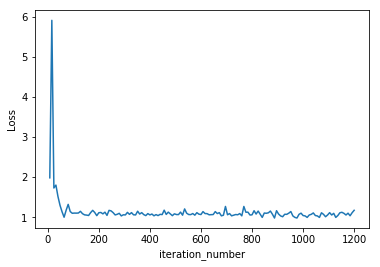

In [36]:
dataloaders = DataLoader(siamese_dataset, shuffle = True, num_workers = num_thread_use, batch_size = batch_size)
print(dataloaders)
net = SiameseNetwork().cuda()
print("Using own defined Loss function")
criterion = Loss()
print("Using small learning rate with momentum")
# optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, net.parameters())), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr = 0.0002 )
print("Creating Learning rate scheduler")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range (num_epoch):
    for i, data in enumerate(dataloaders,0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        exp_lr_scheduler.step()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i %8 == 0 :                     #the value 8 is set according to dataset
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=8
            counter.append(iteration_number)
            loss_history.append(loss.item())
#     print(epoch)
plt.plot(counter,loss_history)
plt.xlabel('iteration_number')
plt.ylabel('Loss')
plt.show()            

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f43c9a9f2b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File 

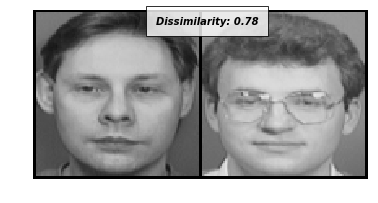

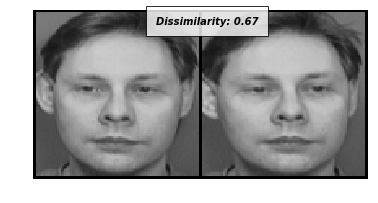

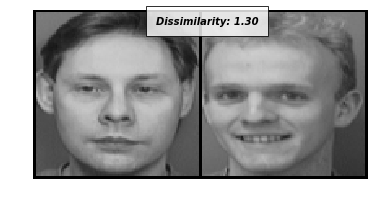

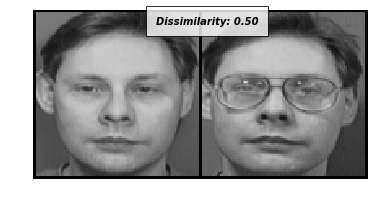

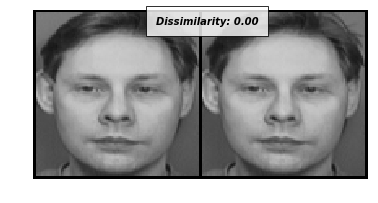

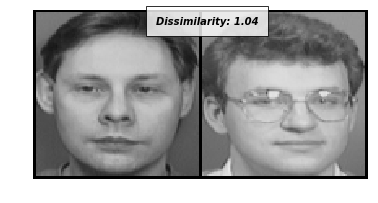

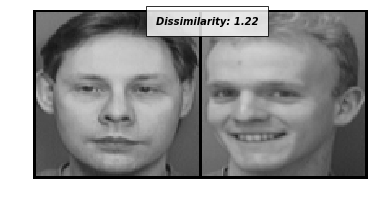

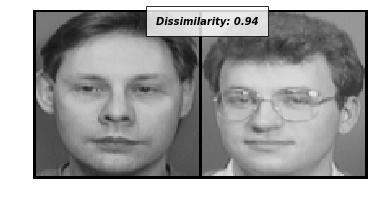

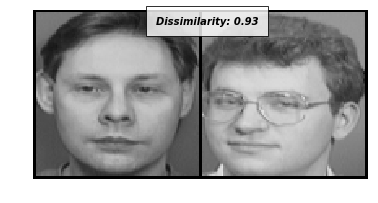

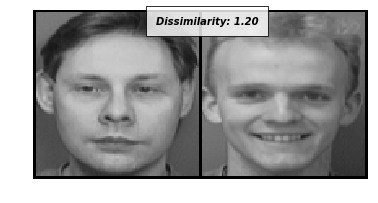

In [37]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
folder_dataset_test = dataset.ImageFolder(root='/home/harsh/project/testing')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=3,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))